# Goals

* Use map-reduce-subgraph framework with SRA tools agent
* Handle GEO record conversion to SRA
* Make sure that the datasets are thoroughly researched
* Handle conversion to SRP accessions

In [1]:
# import 
import os
import re
import time
from pprint import pprint
from datetime import datetime, timedelta
from typing import Annotated, List, Dict, Tuple, Optional, Union, Any
import xml.etree.ElementTree as ET
from pydantic import BaseModel, Field
from langchain_core.tools import tool
from Bio import Entrez
import pandas as pd
from dotenv import load_dotenv

In [30]:
# setup
load_dotenv()
pd.set_option('display.max_colwidth', 1000)
os.environ["DEBUG_MODE"] = "TRUE"

In [ ]:
# checks
if os.getenv("DEBUG_MODE") == "TRUE":
    print("DEBUG_MODE is enabled.")

DEBUG_MODE is enabled.


# Tools

In [33]:
# set up Entrez
Entrez.email = "nick.youngblut@arcinstitute.org"

In [34]:
@tool 
def esearch(
    esearch_query: Annotated[str, "Entrez query string."],
    database: Annotated[str, "Database name ('sra' or 'gds')"]="sra",
    #organism: Annotated[str, "Organism name ('human' or 'mouse')"]="human",
    )-> Annotated[List[str], "Entrez IDs of database records"]:
    """
    Run an Entrez search query and return the Entrez IDs of the results.
    """
    # date range
    start_date = datetime.now() - timedelta(days=7)
    end_date = datetime.now()
    date_range = f"{start_date.strftime('%Y/%m/%d')}:{end_date.strftime('%Y/%m/%d')}[PDAT]"
    esearch_query += f" AND {date_range}"

    # debug model
    if os.getenv("DEBUG_MODE") == "TRUE":
        max_ids = 2 

    # query
    ids = []
    retstart = 0
    retmax = 50
    while True:
        try:
            search_handle = Entrez.esearch(
                db=database, 
                term=esearch_query, 
                retstart=retstart, 
                retmax=retmax
            )
            search_results = Entrez.read(search_handle)
            search_handle.close()
            ids.extend(search_results["IdList"])
            retstart += retmax
            time.sleep(0.5)
            if max_ids and len(ids) >= max_ids:
                break
            if retstart >= int(search_results['Count']):
                break
        except Exception as e:
            print(f"Error searching {database} with query: {esearch_query}: {str(e)}")
            break 
    # return IDs
    return ids[:max_ids]  # debug

#query = '("single cell RNA sequencing" OR "single cell RNA-seq")'
#IDs = esearch.invoke({"esearch_query" : query, "database" : "sra"})
#IDs

In [35]:
@tool 
def efetch(
    database: Annotated[str, "Database name ('sra' or 'gds')"],
    entrez_id: Annotated[str, "Entrez ID"],
    )-> Annotated[List[str], "eFetch results in xml format"]:
    """
    Run an Entrez efetch query on an Entrez ID to obtain metadata for the record.
    """
    time.sleep(0.5)
    # Fetch dataset record
    try:
        handle = Entrez.efetch(db=database, id=entrez_id, retmode="xml")
        record = handle.read()
    except Entrez.Parser.ValidationError:
        print(f"Failed to fetch record for {entrez_id}")
    finally:
        handle.close()
    # decode the record
    try:
        record = record.decode("utf-8")
    except:
        pass

    # check for errors
    if "Error occurred: cannot get document summary" in record:
        return f"Failed to fetch record for {entrez_id}. Try a different database (gds or sra)."

    return str(record)

#record = efetch.invoke({"database" : "sra", "entrez_id" : "35966237"})
#pprint(record)
#record = efetch.invoke({"database" : "gds", "entrez_id" : "200254051"})
#pprint(record)

In [36]:
@tool 
def get_pubmed_article(
    pubmed_id: Annotated[str, "PubMed ID"],
    )-> Annotated[str, "PubMed article metadata in xml format"]:
    """
    Get a PubMed article using Entrez efetch.
    """
    handle = Entrez.efetch(db="pubmed", id=pubmed_id, retmode="xml")
    record = handle.read()
    handle.close()
    try:
        record = record.decode("utf-8")
    except:
        pass
    return str(record)

#get_pubmed_article.invoke({"pubmed_id" : "39492543"})


In [37]:
from subprocess import Popen, PIPE

def run_cmd(cmd: str) -> tuple:
    """
    Run sub-command and return returncode, output, and error.
    Args:
        cmd: Command to run
    Returns:
        tuple: (returncode, output, error)
    """
    p = Popen(cmd, stdout=PIPE, stderr=PIPE, shell=True)
    output, err = p.communicate()
    return p.returncode, output, err

In [38]:
import time

@tool
def run_sra_stat(
    accession: Annotated[str, "SRA accession"],
    tries: Annotated[int, "Number of attempts"]=3
    ) -> str: 
    """
    Run the sra-stat CLI command (SRA Tools) on an SRA accession.
    Use this tool to get information about the sequence data associated with the SRA accession.
    """
    cmd = f'sra-stat --xml --quick {accession}'
    err = ""
    for i in range(tries):
        rc,output,err = run_cmd(cmd)
        if rc == 0:
            return output.decode("utf-8")
        # sleep prior to next attempt
        sleep_time = 5 * (i + 1)
        time.sleep(sleep_time)
    return f"Failed to run sra-stat: {err}"

# run_sra_stat.invoke({"accession" : "SRR13112659"})

In [40]:
@tool 
def geo2sra(
    entrez_ids: Annotated[List[str], "List of Entrez IDs for the GEO database"],
    )-> Annotated[List[str], "List linked Entrez IDs for SRA records"]:
    """
    Convert a GEO Entrez ID to SRA Entrez IDs.
    """
    sra_ids = []
    for entrez_id in entrez_ids:
        # Fetch detailed GEO record to get links to SRA
        handle = Entrez.elink(dbfrom="gds", db="sra", id=entrez_id)
        links = Entrez.read(handle)
        handle.close()
        
        if links[0]['LinkSetDb']:
            sra_ids += [link['Id'] for link in links[0]['LinkSetDb'][0]['Link']]
        time.sleep(0.34) 

    # debug mode
    if os.getenv("DEBUG_MODE") == "TRUE":
        sra_ids = sra_ids[:2]

    return sra_ids

    # Get SRA accessions from IDs
    sra_accessions = []
    for sra_id in sra_ids:
        handle = Entrez.esummary(db="sra", id=sra_id)
        summary = Entrez.read(handle)
        handle.close()
        # Extract SRA accessions from summary
        for entry in summary:
            try:
                run_xml = entry["Runs"]
            except KeyError:
                continue
            
            hit = re.search(r'Run acc="([A-Z]+\d+)"', run_xml)
            if hit:
                sra_accessions.append(hit.group(1))
        # Add delay to comply with NCBI's guidelines
        time.sleep(0.34) 
    if len(sra_accessions) == 0:
        return "No SRA accessions found."

    # return a list of SRA accessions
    return sra_accessions

#geo2sra.invoke({"entrez_ids" : ["200254051"]})
#geo2sra.invoke({"entrez_ids" : ["200268899"]})

# Graph

In [41]:
import operator
from typing import Annotated, Sequence, Tuple, Union, Required
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.types import Send
from langgraph.graph import START, END, StateGraph
from pydantic import BaseModel, Field
from langgraph.prebuilt import create_react_agent, ToolNode

In [42]:
# set model
model = ChatOpenAI(model="gpt-4o-mini")

## Subgraph

In [43]:
class SubState(TypedDict):
    """
    Shared state of the agents in the subgraph
    """
    messages: Annotated[Sequence[BaseMessage], operator.add]
    accessions: Annotated[List[str], "SRA accessions associated with the dataset"]
    is_single_cell: Annotated[bool, "Whether the dataset is a single-cell RNA-seq dataset"]
    explanation: Annotated[str, "Concise determination on whether the dataset is actually a single-cell RNA-seq dataset"]

In [44]:
# create react agent
research_agent = create_react_agent(
    model=model,
    tools=[efetch, run_sra_stat, get_pubmed_article],
    state_modifier=(
        "Based on the provided Entrez record ID, fetch inforamtion about the database record."
        " Use your tools to determine if the dataset is a single-cell RNA-seq dataset."
        " Generally, you will want to use the efetch tool first to get the metadata of the record."
        " Keep researching until you have a clear answer or you have run out of tools."
    )
)

In [45]:
class ResearchSummary(TypedDict):
    """
    Summarize the research results.
    """
    accessions: List[str]
    is_single_cell: bool
    explanation: str 

In [46]:
def summarize_research(state: SubState) -> str:
    """
    Summarize the research results by incorporating previous conversation history.
    """
    # Create a prompt template that includes previous messages
    prompt = ChatPromptTemplate.from_messages([
        # First add any static system message if needed
        ("system", "You will be provided with information on a dataset that may be a single-cell RNA-seq dataset."),
        # Include all previous messages from the state
        MessagesPlaceholder(variable_name="history"),
        # Add the final question/instruction
        ("human", ("Based on the information above, determine whether this dataset is truly a single-cell RNA-seq dataset."
            " Also, provide a concise explanation and any relevant accessions.")
        ),
    ])

    # Format the prompt with the message history
    formatted_prompt = prompt.format_messages(
        history=state["messages"]
    )

    # Use the formatted prompt with the LLM
    return model.with_structured_output(ResearchSummary, strict=True).invoke(formatted_prompt)

# invoke the function
state = {
    "messages": [
        HumanMessage(content="The accession is SRR13112659. The dataset is from a single-cell RNA-seq experiment."),
    ],
    "explanation": ""
}
# summarize_research(state)

In [47]:
#-- subgraph --#
subworkflow = StateGraph(SubState)

# nodes
subworkflow.add_node("research_agent_node", research_agent)
subworkflow.add_node("research_summary_node", summarize_research)

# edges
subworkflow.add_edge(START, "research_agent_node")
subworkflow.add_edge("research_agent_node", "research_summary_node")
subworkflow.add_edge("research_summary_node", END)

# compile the graph
subgraph = subworkflow.compile()

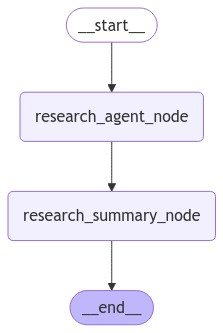

In [48]:
from IPython.display import Image
Image(subgraph.get_graph().draw_mermaid_png())

In [49]:
# Function to invoke the subgraph
def invoke_subgraph(state: SubState):
    message = HumanMessage(content=f"Entrez ID: {state['entrez_id']}, Database: {state['database']}")
    response = subgraph.invoke({
        "database" : state["database"],
        "messages" : [message]
    })
    return {
        "accessions": [response["accessions"]],
        "is_single_cell": [response["is_single_cell"]],
        "explanations": [response["explanation"]]
    }

#ret = invoke_subgraph({"entrez_id" : "36004814", "database" : "sra"})
#ret = invoke_subgraph({"entrez_id" : "35966233", "database" : "sra"})
#ret

In [50]:
# GEO record ID
#ret = invoke_subgraph({"entrez_id" : "200268899", "database" : "gds"})
#ret

## Graph

In [51]:
class TopState(TypedDict):
    """
    Shared state of the agents in the graph
    """
    database: str
    # esearch IDs
    entrez_ids: Annotated[List[str], operator.add]
    # converted IDs
    converted_entrez_ids: Annotated[List[str], operator.add]
    # accessions
    accessions: Annotated[List[List[str]], operator.add]
    # is_single_cell
    is_single_cell: Annotated[List[bool], operator.add]
    # explanations
    explanations: Annotated[List[str], operator.add]

In [52]:
def invoke_esearch(state: TopState):
    query = '("single cell RNA sequencing" OR "single cell RNA-seq")'
    entrez_ids = esearch.invoke({"esearch_query" : query, "database" : state["database"]})
    return {"entrez_ids" : entrez_ids}

# create react agent
def invoke_sra2geo(state: TopState):
    """
    Invoke the geo2sra tool to get SRA accessions for a GEO dataset.
    """
    # invoke tool
    sra_ids = geo2sra.invoke({"entrez_ids" : state["entrez_ids"]})
    # update state
    return {"converted_entrez_ids" : sra_ids, "database" : "sra"}

# ID conversion router
def id_convert_router(state: TopState):
    """
    Route the Entrez IDs to the appropriate conversion tool.
    """
    if state["database"] == "gds":
        return ["id_convert_node"]
    else:
        return ["id_next_node"]

def id_next(state: TopState):
    """
    Determine the next step based on the database.
    """
    return {"database" : state["database"]}

# Parallel invoke of the subgraph
def continue_to_subgraphs(state: TopState):
    # check if there are any converted IDs
    if len(state["converted_entrez_ids"]) > 0:
        entrez_ids = state["converted_entrez_ids"]
    else:
        entrez_ids = state["entrez_ids"]
    # invoke the subgraph for each ID
    return [Send("invoke_subgraph", {"entrez_id": x, "database" : state["database"]}) for x in entrez_ids]

def final_state(state: TopState):
    # which entrez IDs to return?
    entrez_ids = []
    if len(state["converted_entrez_ids"]) > 0:
        entrez_ids = state["converted_entrez_ids"]
    else:
        entrez_ids = state["entrez_ids"]
    # return final state
    return {
        "database": state["database"],
        "entrez_id": entrez_ids,
        "accession": state["accessions"],
        "is_single_cell": state["is_single_cell"],
        "explanation": state["explanations"]
    }

In [53]:
#-- graph --#
workflow = StateGraph(TopState)

# nodes
workflow.add_node("esearch_node", invoke_esearch)
workflow.add_node("id_convert_node", invoke_sra2geo)
workflow.add_node("id_next_node", id_next)
workflow.add_node("invoke_subgraph", invoke_subgraph)
workflow.add_node("final_state_node", final_state)

# edges
workflow.add_edge(START, "esearch_node")
workflow.add_conditional_edges("esearch_node", id_convert_router, ["id_convert_node", "id_next_node"])
workflow.add_edge("id_convert_node", "id_next_node")
workflow.add_conditional_edges("id_next_node", continue_to_subgraphs, ["invoke_subgraph"])
workflow.add_edge("invoke_subgraph", "final_state_node")
workflow.add_edge("final_state_node", END)

# compile the graph
graph = workflow.compile()

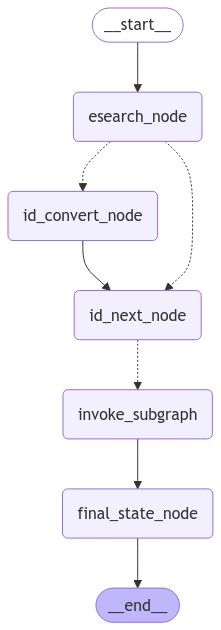

In [54]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [ ]:
# Call the graph: SRA database
# final_state = None
# for step in graph.stream({"database": "sra"}, subgraphs=True, config={"max_concurrency" : 2, "recursion_limit": 30}):
#     print(step)
#     final_state = step

In [25]:
# Call the graph: GEO database
final_state = None
for step in graph.stream({"database": "gds"}, subgraphs=True, config={"max_concurrency" : 2, "recursion_limit": 30}):
    print(step)
    final_state = step

((), {'esearch_node': {'entrez_ids': ['200248086', '200241287']}})
((), {'id_convert_node': {'database': 'sra', 'converted_entrez_ids': ['30554141', '30554140', '28886215', '28886214', '28886213', '28886212', '28886211']}})
((), {'id_next_node': {'database': 'sra'}})
(('invoke_subgraph:4812dbd1-b896-fd5b-5847-b1e5c08d065e', 'research_agent_node:69e7a0d3-91de-e191-e465-373f0b395dc4'), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rXX5lu98tToqbLszRSnmnOsB', 'function': {'arguments': '{"database":"sra","entrez_id":"30554141"}', 'name': 'efetch'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 268, 'total_tokens': 292, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_finger

In [26]:
# get final state
final_state

((),
 {'final_state_node': {'database': 'sra',
   'is_single_cell': [True, True, True, True, True, True, True],
   'explanation': ['This dataset is a single-cell RNA sequencing (scRNA-seq) dataset, as it involves the isolation of single CD8+ splenocytes from immunized C57BL/6 mice and utilizes the 10x Genomics platform for single-cell capture and library construction.',
    'The dataset involves single-cell RNA sequencing (scRNA-seq) of CD8+ splenocytes isolated from C57BL/6 mice immunized with an mRNA vaccine. The library construction utilized the 10x Genomics technology specifically designed for single-cell analysis.',
    'The dataset involves single-cell RNA sequencing (scRNA-seq) of human primordial germ cell-like cells (PGCLCs) at different time points during induction. The library construction protocols specifically mentioned the use of techniques designed for single-cell analysis, including FACS sorting and 10X Genomics technology, confirming its status as a single-cell RNA-seq

In [27]:
# convert to a dataframe
results = pd.DataFrame(final_state[1]['final_state_node'])
results

,database,is_single_cell,explanation
0,sra,True,"This dataset is a single-cell RNA sequencing (scRNA-seq) dataset, as it involves the isolation of single CD8+ splenocytes from immunized C57BL/6 mice and utilizes the 10x Genomics platform for single-cell capture and library construction."
1,sra,True,The dataset involves single-cell RNA sequencing (scRNA-seq) of CD8+ splenocytes isolated from C57BL/6 mice immunized with an mRNA vaccine. The library construction utilized the 10x Genomics technology specifically designed for single-cell analysis.
2,sra,True,"The dataset involves single-cell RNA sequencing (scRNA-seq) of human primordial germ cell-like cells (PGCLCs) at different time points during induction. The library construction protocols specifically mentioned the use of techniques designed for single-cell analysis, including FACS sorting and 10X Genomics technology, confirming its status as a single-cell RNA-seq dataset."
3,sra,True,"The dataset involves single-cell RNA sequencing (scRNA-seq) analysis of primordial germ cell-like cells (PGCLCs) at different time points. It utilizes the 10X Genomics platform for library preparation and sequencing, which is specifically designed for single-cell applications. The methods described, such as FACS sorting of live single cells prior to sequencing, further confirm the single-cell nature of the dataset."
4,sra,True,"The dataset includes transcriptomic data generated from single-cell RNA sequencing (scRNA-seq) of human primordial germ cell-like cells (PGCLCs) at various time points. It involves the use of FACS to isolate live single cells, and the library preparation was specifically designed for single-cell analysis using the 10X Genomics platform."
5,sra,True,"The dataset is confirmed to be a single-cell RNA-seq dataset based on its library source labeled as 'TRANSCRIPTOMIC SINGLE CELL', the library strategy being 'RNA-Seq', and the specific mention of sorting live single cells for analysis. It focuses on the differentiation of primordial germ cell-like cells (PGCLCs) at various time points."
6,sra,True,"The dataset is confirmed to be a single-cell RNA-seq dataset based on its library source labeled as 'TRANSCRIPTOMIC SINGLE CELL', the utilization of FACS sorting for isolating single cells, and the generation of libraries using 10X Genomics technology specifically designed for single-cell sequencing."
